In [24]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from implicit.als import AlternatingLeastSquares

In [25]:
# Step 1: Generate a DataFrame with 10000 rows

np.random.seed(42)  # For reproducibility

# Randomly generate customer and product data
customers = ['C' + str(i) for i in range(1, 201)]  # 200 unique customers
products = ['P' + str(i) for i in range(1, 51)]  # 50 unique products

# Randomly assign interactions (interaction_type: 1 for interaction, 0 for no interaction)
customer_ids = np.random.choice(customers, 10000)
product_ids = np.random.choice(products, 10000)
interaction_types = np.random.choice([1], 10000)  # Assuming 1 means interaction (viewed/purchased)
interaction_dates = pd.to_datetime(np.random.choice(pd.date_range('2023-01-01', '2024-12-31', freq='D'), 10000))

# Create the DataFrame
df = pd.DataFrame({
    'customer_id': customer_ids,
    'product_id': product_ids,
    'interaction_type': interaction_types,
    'interaction_date': interaction_dates
})


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customer_id       10000 non-null  object        
 1   product_id        10000 non-null  object        
 2   interaction_type  10000 non-null  int32         
 3   interaction_date  10000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(1), object(2)
memory usage: 273.6+ KB


In [27]:
df.describe()

,interaction_type,interaction_date
count,10000.0,10000
mean,1.0,2024-01-01 21:32:24
min,1.0,2023-01-01 00:00:00
25%,1.0,2023-07-02 00:00:00
50%,1.0,2024-01-03 00:00:00
75%,1.0,2024-07-06 00:00:00
max,1.0,2024-12-31 00:00:00
std,0.0,NaN


In [28]:
df.head(5)

,customer_id,product_id,interaction_type,interaction_date
0,C103,P14,1,2024-01-11
1,C180,P27,1,2024-12-30
2,C93,P25,1,2023-09-03
3,C15,P13,1,2023-10-30
4,C107,P21,1,2024-02-09


In [29]:
# Step 2: Data Preprocessing (Label Encoding)
le_customer = LabelEncoder()
le_product = LabelEncoder()

df['customer_id_encoded'] = le_customer.fit_transform(df['customer_id'])
df['product_id_encoded'] = le_product.fit_transform(df['product_id'])


In [30]:
# Step 3: Create Interaction Matrix
# Aggregate duplicate entries by taking the maximum interaction type (e.g., most significant interaction)
df_aggregated = df.groupby(['customer_id', 'product_id'], as_index=False)['interaction_type'].max()

# Create the user-item interaction matrix
interaction_matrix = df_aggregated.pivot(index='customer_id', columns='product_id', values='interaction_type').fillna(0)

# Convert to a sparse matrix for further processing

interaction_matrix_sparse = csr_matrix(interaction_matrix.values)

# Print the resulting matrix shape for verification
print(f"Interaction Matrix Shape: {interaction_matrix.shape}")

Interaction Matrix Shape: (200, 50)


In [34]:
# Step 4: Build the ALS (Collaborative Filtering) Model
model = AlternatingLeastSquares(factors=10, regularization=0.1, iterations=30)
model.fit(interaction_matrix_sparse)

  0%|          | 0/30 [00:00<?, ?it/s]

In [35]:
def get_collaborative_recommendations(customer_id, model, interaction_matrix_sparse, top_n=5):
    # Ensure customer ID exists in the interaction matrix
    if customer_id not in interaction_matrix.index:
        raise ValueError(f"Customer ID {customer_id} not found in the interaction matrix.")
    
    customer_idx = interaction_matrix.index.get_loc(customer_id)  # Get the index of the customer
    
    # Get top N recommendations
    recommendations = model.recommend(customer_idx, interaction_matrix_sparse, N=top_n, filter_already_liked_items=False)
    
    # Map the recommended product indices back to product IDs
    product_ids = [le_product.inverse_transform([rec[0]])[0] for rec in recommendations]
    scores = [rec[1] for rec in recommendations]
    
    return list(zip(product_ids, scores))

In [36]:
# Example usage
try:
    customer_id =  9.0 # Ensure this customer ID exists in the index
    recommended_products = get_collaborative_recommendations(customer_id, model, interaction_matrix_sparse, top_n=5)
    print(f"Recommended products for customer {customer_id}: {recommended_products}")
except ValueError as e:
    print(e)


Customer ID 9.0 not found in the interaction matrix.


In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix

In [39]:
# Split the data into training and testing sets (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [40]:
# Sort by interaction_date to retain the most recent interaction
test_df_sorted = test_df.sort_values('interaction_date', ascending=False)

# Drop duplicates, keeping the most recent interaction
test_df_sorted = test_df_sorted.drop_duplicates(subset=['customer_id_encoded', 'product_id_encoded'], keep='first')

# Create the interaction matrix for the test set
test_matrix = test_df_sorted.pivot(index='customer_id_encoded', columns='product_id_encoded', values='interaction_type').fillna(0)


In [41]:
# Step 1: Handle duplicates by aggregating interaction values
train_df_agg = train_df.groupby(['customer_id_encoded', 'product_id_encoded'], as_index=False)['interaction_type'].max()

# Step 2: Create Interaction Matrices for Train and Test sets
train_matrix = train_df_agg.pivot(index='customer_id_encoded', columns='product_id_encoded', values='interaction_type').fillna(0)

# Convert to sparse matrix format for ALS model

train_matrix_sparse = csr_matrix(train_matrix.values)
test_matrix_sparse = csr_matrix(test_matrix.values)

# Check the resulting matrices
print("Train Matrix:")
print(train_matrix.head())
print("\nTest Matrix:")
print(test_matrix.head())


Train Matrix:
product_id_encoded    0    1    2    3    4    5    6    7    8    9   ...  \
customer_id_encoded                                                    ...   
0                    0.0  1.0  0.0  1.0  0.0  1.0  0.0  0.0  1.0  1.0  ...   
1                    1.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  ...   
2                    1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  ...   
3                    1.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...   
4                    1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  ...   

product_id_encoded    40   41   42   43   44   45   46   47   48   49  
customer_id_encoded                                                    
0                    0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
1                    1.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  
2                    0.0  0.0  0.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  
3                    0.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  
4      

In [43]:
# Step 3: Train the als Model on the Training Data
model = AlternatingLeastSquares(factors=10, regularization=0.1, iterations=30)
model.fit(train_matrix_sparse)

  0%|          | 0/30 [00:00<?, ?it/s]

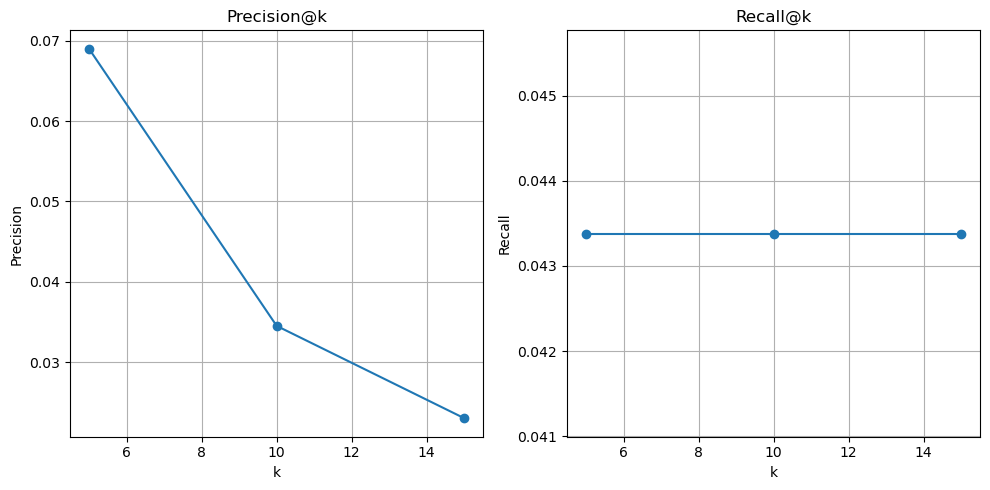

In [44]:
def calculate_precision_recall_at_k(model, test_matrix, k=5):
    precision_list = []
    recall_list = []
    
    for customer_idx in range(test_matrix.shape[0]):
        # Get the true interactions for the customer from the test matrix
        true_interactions = test_matrix.iloc[customer_idx].values.flatten()  # Use .values instead of .toarray()
        
        # Get top k recommendations for the customer
        recommendations = model.recommend(customer_idx, test_matrix_sparse, N=k, filter_already_liked_items=False)
        
        # Get the recommended product indices (convert to integers if necessary)
        recommended_indices = [int(rec[0]) for rec in recommendations]
        
        # Ensure recommended_indices are within the valid range
        recommended_indices = [idx for idx in recommended_indices if idx < len(true_interactions)]
        
        # Calculate true positives for precision and recall using boolean indexing
        true_positives = np.sum(true_interactions[recommended_indices] > 0)
        
        # Precision = true positives / k
        precision = true_positives / k if k > 0 else 0
        
        # Recall = true positives / sum of actual interactions
        relevant_items = np.sum(true_interactions > 0)
        recall = true_positives / relevant_items if relevant_items > 0 else 0
        
        precision_list.append(precision)
        recall_list.append(recall)
    
    return np.mean(precision_list), np.mean(recall_list)

# Step 5: Evaluate Precision and Recall for different k values
precision_values = []
recall_values = []
k_values = [5, 10, 15]

for k in k_values:
    precision, recall = calculate_precision_recall_at_k(model, test_matrix, k)
    precision_values.append(precision)
    recall_values.append(recall)

# Step 6: Plot Precision and Recall at k
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Precision Plot
plt.subplot(1, 2, 1)
plt.plot(k_values, precision_values, marker='o', label='Precision')
plt.title('Precision@k')
plt.xlabel('k')
plt.ylabel('Precision')
plt.grid(True)

# Recall Plot
plt.subplot(1, 2, 2)
plt.plot(k_values, recall_values, marker='o', label='Recall')
plt.title('Recall@k')
plt.xlabel('k')
plt.ylabel('Recall')
plt.grid(True)

plt.tight_layout()
plt.show()


In [45]:
def get_final_recommendations(model, test_matrix, k=5):
    recommendations_dict = {}  # To store recommendations for each customer
    
    for customer_idx in range(test_matrix.shape[0]):
        # Get top k recommendations for the customer
        recommendations = model.recommend(customer_idx, test_matrix_sparse, N=k, filter_already_liked_items=False)
        
        # Store the recommended products and their scores
        recommended_products = [(rec[0], rec[1]) for rec in recommendations]  # (product_id, score)
        
        recommendations_dict[customer_idx] = recommended_products
    
    return recommendations_dict

# Get final recommendations for each customer
final_recommendations = get_final_recommendations(model, test_matrix, k=5)

# Display final recommendations for each customer
for customer_idx, recommendations in final_recommendations.items():
    print(f"Customer {customer_idx} - Top 5 Recommendations:")
    for product_id, score in recommendations:
        print(f"  Product ID: {product_id}, Score: {score}")
    print("\n")


Customer 0 - Top 5 Recommendations:
  Product ID: 41, Score: 15
  Product ID: 1.0299433469772339, Score: 0.9310365319252014


Customer 1 - Top 5 Recommendations:
  Product ID: 18, Score: 30
  Product ID: 1.4056768417358398, Score: 1.2398996353149414


Customer 2 - Top 5 Recommendations:
  Product ID: 49, Score: 30
  Product ID: 1.1316238641738892, Score: 1.0745068788528442


Customer 3 - Top 5 Recommendations:
  Product ID: 25, Score: 14
  Product ID: 1.2495059967041016, Score: 1.2080225944519043


Customer 4 - Top 5 Recommendations:
  Product ID: 21, Score: 33
  Product ID: 0.8294808268547058, Score: 0.8255587220191956


Customer 5 - Top 5 Recommendations:
  Product ID: 32, Score: 14
  Product ID: 1.3790282011032104, Score: 1.2277748584747314


Customer 6 - Top 5 Recommendations:
  Product ID: 32, Score: 38
  Product ID: 1.227152705192566, Score: 1.067745327949524


Customer 7 - Top 5 Recommendations:
  Product ID: 33, Score: 23
  Product ID: 1.0184625387191772, Score: 0.9314831495285